In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.models.blei_lafferty_score import BleiLaffertyScore

from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Get dataset

In [5]:
DATA_PATH = "Pscience.csv"

In [6]:
dataset = Dataset(DATA_PATH)
dictionary = dataset.get_dictionary()

### Make initial model

In [7]:
from topicnet.cooking_machine.model_constructor import init_simple_default_model

n_topics = 200
n_background = 10
model_artm = init_simple_default_model(
    dataset=dataset,
    modalities_to_use=dataset.get_possible_modalities(),
    main_modality='@word',
    specific_topics=n_topics - n_background,
    background_topics=n_background,
)
specific_topics, background_topics = model_artm.topic_names[:-n_background], model_artm.topic_names[-n_background:]
model_artm.scores

[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@word, PerplexityScore@word, TopicKernel@word]

In [8]:
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(
        name="decorrelation_phi",
        topic_names=specific_topics,
        class_ids=dataset.get_possible_modalities()))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(
        name="smooth_phi",
        topic_names=background_topics,
        class_ids=dataset.get_possible_modalities(),
        tau=0.1))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(
        name="smooth_theta",
        topic_names=background_topics,
        tau=0.1))

### Define Topic Model

In [9]:
model = TopicModel(model_artm, model_id='MuratDemo', scores="BleiLaffertyScore")
model.custom_scores['BleiLaffertyScore'] = BleiLaffertyScore()
model.custom_scores

{'BleiLaffertyScore': <topicnet.cooking_machine.models.blei_lafferty_score.BleiLaffertyScore at 0x7f5ffeebd2b0>}

In [10]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./MuratDemo') == True:
    os.system("rm -rf ./MuratDemo")
experiment = Experiment(experiment_id='MuratDemo', save_path='MuratDemo', topic_model=model)

### Cubes

In [11]:
cube_0 = RegularizersModifierCube(
    num_iter=1,
    reg_search='grid',
    regularizer_parameters=[{
            'name':"smooth_phi",
            'tau_grid':[0.1]},
        {
            'name':"smooth_theta",
            'tau_grid':[0.1]
        }],
    verbose=False,
    relative_coefficients=True)
cube_1 = RegularizersModifierCube(
    num_iter=20,
    reg_search='add',
    strategy=PerplexityStrategy(
            start_point=0,
            step=1000,
            max_len=10000),
    regularizer_parameters={
        'name':"decorrelation_phi"},
    # parameters of this strategy are intended for revision
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    verbose=False,
    relative_coefficients=False)

In [12]:
start_time = time.time()
models = cube_0(model, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.610719203948975 seconds ---


In [13]:
models = experiment.select(f'PerplexityScore@all -> min COLLECT 1')

In [14]:
start_time = time.time()
models = cube_1(models, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:278: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning[0])


--- 6446.833783149719 seconds ---


In [33]:
models = experiment.select(f'PerplexityScore@all < 1.01 * MINIMUM(PerplexityScore@all) and BleiLaffertyScore -> max')

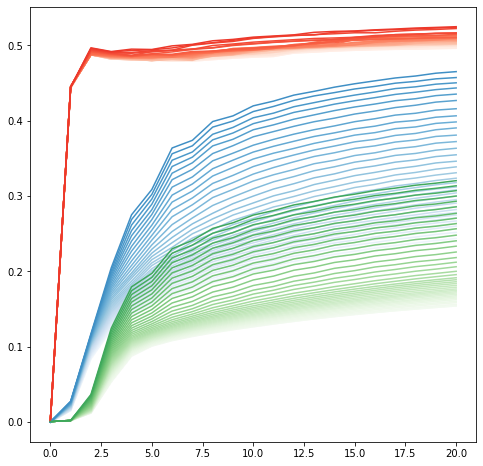

In [34]:
from matplotlib import cm
import numpy as np


tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
    score = tm.scores['SparsityThetaScore']
    plt.plot(score, color=cm.Greens(colors[i]))
plt.show()

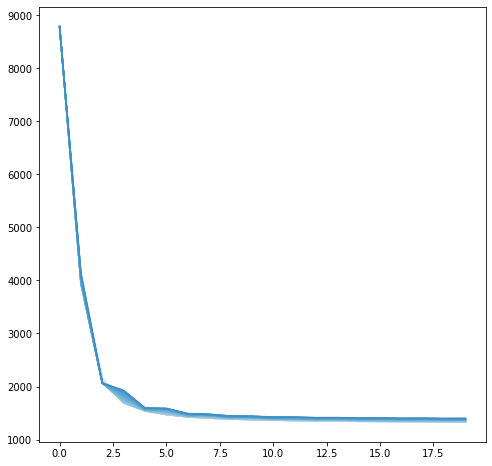

In [35]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:], color=cm.Blues(colors[i]))
plt.show()

### Investigate model

In [36]:
best_model = models[0]

In [37]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw

In [38]:
thresh = 1e-5
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=dataset).view()

In [39]:
n=7
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[:n]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_title = get_modality_vw(doc_vw, "@title")
        display_html(f"<b>{doc_title}</b>", raw=True)

,topic_0 @word
rutube,0.02159
рождение,0.02022
архитектура,0.01822
неплохой,0.01363
обещание,0.00937
модератор,0.00784
russia,0.0077
проектирование,0.00671
воровать,0.00555
партнёрский,0.00457


,topic_1 @word
запрет,0.03257
дробный,0.0302
ранжирование,0.01862
азартный,0.01546
коэффициент,0.00779
фильтр,0.00716
wsgi,0.00647
критерий,0.00592
казино,0.00589
актуальность,0.00537


,topic_2 @word
тв,0.04248
широкополосный,0.03829
телевидение,0.0333
тариф,0.03041
стрим,0.02453
предоставление,0.02292
тарифный,0.02069
мтуинтел,0.01581
кабельный,0.01573
абонентский,0.01545


,topic_3 @word
software,0.03019
анимация,0.01914
macromedia,0.01127
flock,0.00844
джонатан,0.0064
группировка,0.00634
player,0.00565
наведение,0.00545
animator,0.00513
вкладка,0.00486


,topic_4 @word
inc,0.0381
journal,0.02556
street,0.02245
иностранный,0.02189
wall,0.01885
интернетпровайдер,0.01458
ботнет,0.01383
порог,0.0119
кбитс,0.01159
валюта,0.01004


,topic_5 @word
лебедев,0.05283
артемий,0.02363
o,0.02244
вставка,0.00989
эмоция,0.0079
хабраюзер,0.00768
длина,0.00758
twitter,0.00633
смайлик,0.00466
sms,0.00446


,topic_6 @word
юзер,0.04492
aol,0.02929
allofmpcom,0.01934
blinkx,0.01017
вто,0.00873
закрытие,0.00868
вступление,0.00851
mediaservices,0.00583
соня,0.00575
visa,0.00566
